## Notebook for applying Data Assimilation on seasonal data (PWP reconstructions)

Author: **N.J. de Winter** (*n.j.de.winter@vu.nl*)<br>
Assitant Professor Vrije Universiteit Amsterdam

In [22]:
# Load packages
import numpy as np # The 'numpy' package is needed for matrix operations and calculations
import pandas as pd # The 'pandas' package helps us to import and manage data
import math as math # Math package for data cleaning
from scipy import stats # Import scipy.stats package for confidence intervals
# ---TO DO: Install D47calib and use here--- https://github.com/mdaeron/D47calib
# import D47calib as D47c # Import the package for treating clumped isotope data by Daëron and Vermeesch (2023)
import matplotlib.pyplot as plt # The 'matplotlib' package contains tools needed to plot our data and results
%matplotlib inline

# PRIOR
## Load monthly model data

In [23]:
# Load model data as prior and show data structure
PlioMIP = pd.read_csv('PWP case/PlioMIP_SST.csv') # Load the data for this assignment into Python and in the Jupyter environment.
PlioMIP.head()

,modelname,ja,fb,mr,ar,my,jn,jl,ag,sp,ot,nv,dc
0,CCSM4-UoT,8.33,7.14,7.45,9.67,13.33,18.40,22.50,24.35,22.60,18.74,14.83,10.86
1,CCSM4-Utr,9.96,8.75,8.95,11.03,14.62,19.37,23.50,25.29,23.95,20.76,16.37,12.48
2,COSMOS,7.91,6.68,6.38,7.34,9.53,12.23,14.95,15.94,14.94,13.34,11.49,9.58
3,EC-Earth3.3,9.18,7.62,7.41,9.32,13.58,19.22,24.06,25.27,23.56,20.26,16.05,12.13
4,GISS2.1G,4.87,3.58,3.88,6.75,11.21,15.56,18.68,19.39,17.68,14.47,10.53,7.18


## Seasonal model data

In [24]:
# Define the seasons
seasons = {
    "winter": ["dc", "ja", "fb"],
    "spring": ["mr", "ar", "my"],
    "summer": ["jn", "jl", "ag"],
    "autumn": ["sp", "ot", "nv"],
}

# Stack monthly columns to create a seasonal dataframe
PlioMIP_seasonal = {}
for season, months in seasons.items():
    PlioMIP_seasonal[season] = pd.concat([PlioMIP[month] for month in months], ignore_index = True)

# Add model names
PlioMIP_seasonal["modelname"] = np.tile(PlioMIP["modelname"], len(seasons["winter"]))

# Convert the seasonal data into a DataFrame
PlioMIP_seasonal = pd.DataFrame(PlioMIP_seasonal)

# Display the new seasonal DataFrame
PlioMIP_seasonal.head()

,winter,spring,summer,autumn,modelname
0,10.86,7.45,18.40,22.60,CCSM4-UoT
1,12.48,8.95,19.37,23.95,CCSM4-Utr
2,9.58,6.38,12.23,14.94,COSMOS
3,12.13,7.41,19.22,23.56,EC-Earth3.3
4,7.18,3.88,15.56,17.68,GISS2.1G


## Monthly prior

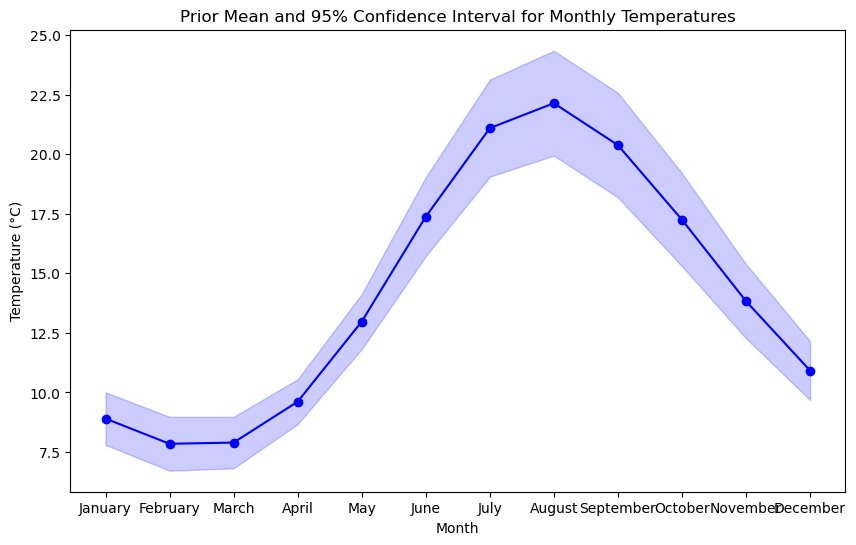

In [25]:
# Establish and plot prior distribution based on PlioMIP model outcomes

# Set dimensions of data
n_months = len(PlioMIP.iloc[1,:]) - 1
n_models = len(PlioMIP["ja"])

# Prior estimates from climate models (mean and covariance of season)
mu_prior = PlioMIP.iloc[:,1:13].mean() # Calculate monthly mean model temperature
cov_prior = np.cov(PlioMIP.iloc[:,1:13], rowvar = False) # Prior covariance matrix

# Store copy of original prior means
mu_prior_original, cov_prior_original = mu_prior.copy(), cov_prior.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior = np.sqrt(np.diag(cov_prior))

# Plot monthly prior distribution
# Plotting the prior mean and uncertainty
months = np.arange(1, n_months + 1) # Create monthly scale
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(10, 6))
plt.plot(months, mu_prior, label = 'Prior Mean', color = 'b', marker = 'o')
plt.title('Prior Mean and 95% Confidence Interval for Monthly Temperatures')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')

# Adding 95% confidence intervals (mean ± t_inv * standard deviation)
plt.fill_between(months,
    mu_prior - stats.t.ppf(1 - 0.025, n_models) * std_prior / np.sqrt(n_models),
    mu_prior + stats.t.ppf(1 - 0.025, n_models) * std_prior / np.sqrt(n_models), 
    color='b',
    alpha = 0.2,
    label='95% Confidence Interval'
)

# Update the x-axis with month names
plt.xticks(months, month_names)
plt.show() # Show plot

## Seasonal prior

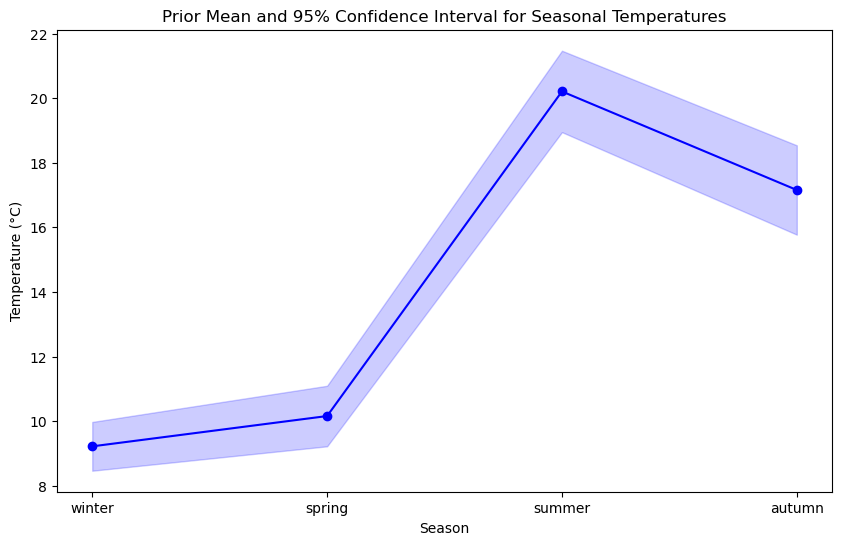

In [26]:
# Establish and plot prior distribution based on seasonal PlioMIP model outcomes

# Set dimensions of data
n_seasons_scale = len(PlioMIP_seasonal.iloc[1,:]) - 1
n_models_seasonal = len(PlioMIP_seasonal["summer"])
season_names = seasons.keys()

# Prior estimates from climate models (mean and covariance of season)
mu_prior_seasonal = PlioMIP_seasonal[season_names].mean() # Calculate seasonal mean model temperature
cov_prior_seasonal = np.cov(PlioMIP_seasonal[seasons.keys()], rowvar=False) # Prior covariance matrix

# Store copy of original prior means
mu_prior_seasonal_original, cov_prior_seasonal_original = mu_prior_seasonal.copy(), cov_prior_seasonal.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_seasonal = np.sqrt(np.diag(cov_prior_seasonal))

# Plot seasonal prior distribution
# Plotting the prior mean and uncertainty
seasons_scale = np.arange(1, n_seasons_scale + 1) # Create seasonal scale

plt.figure(figsize = (10, 6))
plt.plot(seasons_scale, mu_prior_seasonal, label = 'Prior Mean', color = 'b', marker = 'o')
plt.title('Prior Mean and 95% Confidence Interval for Seasonal Temperatures')
plt.xlabel('Season')
plt.ylabel('Temperature (°C)')

# Adding 95% confidence intervals (mean ± 1.96 * standard deviation)
plt.fill_between(seasons_scale,
    mu_prior_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# Update the x-axis with month names
plt.xticks(seasons_scale, season_names)
plt.show() # Show plot

# UPDATE
## Load clumped data for updating
### Seasonal data from PWP paper

In [27]:
# Load measurements and format them into a dictionary
PWP_D47_seasonal = pd.read_csv('PWP case/PWP_proxy_data_seasonal.csv') # Load the data for this assignment into Python and in the Jupyter environment.
PWP_D47_seasonal_dict = PWP_D47_seasonal.to_dict('records') # Convert to dictionary with column headers as keys
print(PWP_D47_seasonal_dict) # Print to check the structure of the data

[{'season_score': 4, 'd13C': 1.163185755, 'd13C.lower': 0.779157572, 'd13C.upper': 1.354243212, 'd13C_sd': 0.287845755, 'd18O': 2.290168712, 'd18O.lower': 2.121157663, 'd18O.upper': 2.48333174, 'd18O_sd': 0.181277819, 'D47': 0.610081855, 'D47.lower': 0.594175238, 'D47.upper': 0.61649739, 'D47_sd': 0.011172835, 'T_mean': 21.42, 'temp.lower': 19.15042268, 'temp.upper': 26.9231683, 'T_sd': 3.890467215, 'd18Ow': 2.770476926, 'd18Ow.lower': 2.212932741, 'd18Ow.upper': 3.911848228, 'd18Ow_sd': 0.850352672, 'Specimen': 'SG105', 'Species': 'Pygocardia rustica', 'N': 6, 'method': 'strict', 'season2': 'summer', 'season': 3}, {'season_score': 2, 'd13C': 1.257226796, 'd13C.lower': 1.01312064, 'd13C.upper': 1.337010987, 'd13C_sd': 0.486170022, 'd18O': 2.239117264, 'd18O.lower': 2.161504018, 'd18O.upper': 2.340720145, 'd18O_sd': 0.269009278, 'D47': 0.637347382, 'D47.lower': 0.63185791, 'D47.upper': 0.644784026, 'D47_sd': 0.019402524, 'T_mean': 13.09, 'temp.lower': 10.77487492, 'temp.upper': 14.63025

### Monthly data (work in progress)

In [28]:
# Load measurements and format them into a dictionary
PWP_D47 = pd.read_csv('PWP case/PWP_proxy_data_months.csv') # Load the data for this assignment into Python and in the Jupyter environment.
PWP_D47_dict = PWP_D47.to_dict('records') # Convert to dictionary with column headers as keys
print(PWP_D47_dict) # Print to check the structure of the data

[{'Date': '21/04/2022 13:26', 'Sample_name': 'Pygocardia A2', 'Run': 234, 'ID': 'BG', 'Row': 5, 'Int': 18203.792, 'par49': 0.000541427, 'd47': 18.43919802, 'd47_SE': 0.019680173, 'D47_Raw': -0.229883662, 'D47_SD': 0.117771893, 'D47_final': 0.6237, 'Final_d18O': 2.239117264, 'Final_d13C': -0.397061707, 'OUTLIER': False, 'Specimen': 'SG105', 'Species': 'Pygocardia rustica', 'Sample_nr': '2', 'Datetime': '21/04/2022 13:26', 'Sample_or_Standard': 'Sample', 'Sample_or_Standard2': 'Sample', 'D47_offset_corr_strict': 0.630410712, 'D47_offset_N_strict': '40', 'D47_accepted': nan, 'D47_corrETF_strict': 0.621082944, 'D47_acc': nan, 'Instrument': 'PACMAN', 'D47_sd_ext': 0.049933999, 'd18O_sd_ext': 0.092848257, 'd13C_sd_ext': 0.141236548, 'mineral': 'aragonite', 'temp_strict': 17.70589374, 'd18Ow_strict': 3.123629307, 'Sample_nr2': 2.0, 'Dist': 61.7160274, 'ShellChron_Age': 2579.385569, 'ShellChron_DOY': 24.38556935, 'ShellChron_DOY_err': nan, 'month_score': 1, 'month': 'January', 'temp_strict_SD'

## Create updating function (Kalman filter)
### NOTE: Kalman filter assumes normality of the distribution

In [29]:
# Create updating function
def kalman_update(
    mu_prior,
    cov_prior,
    measurement,
    timestamp,
    Temperature_name = "T_mean",
    Temperature_name_SD = "T_sd",
):
    try:
        time = int(measurement[timestamp]) - 1
        obs_temp = measurement[Temperature_name]
        obs_var = measurement[Temperature_name_SD] ** 2

        if not np.isnan(time) and not np.isnan(obs_temp) and not np.isnan(obs_var):
            # Prior mean and variance for the specific time
            mu_prior_time = mu_prior[time]
            cov_prior_time = cov_prior[time, time]

            # Kalman gain
            K = cov_prior_time / (cov_prior_time + obs_var)

            # Update mean and variance
            mu_post = mu_prior_time + K * (obs_temp - mu_prior_time)
            cov_post = (1 - K) * cov_prior_time

            # Update the prior arrays with the new posterior values
            mu_prior[time] = mu_post
            cov_prior[time, time] = cov_post

        return mu_prior, cov_prior  # Ensure this return statement is reached

    except (KeyError, TypeError, ValueError) as e:
        print(f"Error in kalman_update: {e}")
        return mu_prior, cov_prior  # Return the unmodified values even on error to prevent errors during the looping later

### FIXME: Alternative updating function based on Bayesian importance sampling

In [ ]:
# Number of samples for the prior
n_samples = 10000

posterior_samples = prior_samples.copy()
for measurement in measurements:
    month = measurement['month']
    obs_temp = measurement['temperature']
    obs_sigma = measurement['uncertainty']
    
    # Compute likelihood weights for the samples
    weights = np.exp(-0.5 * ((posterior_samples[month] - obs_temp) / obs_sigma) ** 2)
    weights /= np.sum(weights)  # Normalize weights
    
    # Resample based on weights
    posterior_samples[month] = np.random.choice(
        posterior_samples[month], size = n_samples, p = weights
    )

## Update seasonal prior with data

In [30]:
# Update the seasonal prior with all measurements
seasonal_data = {} # Keep track of datapoints per season
for measurement in PWP_D47_seasonal_dict: # Loop over measurements
    # This aggregates the data to update the prior to the posterior
    mu_prior_seasonal, cov_prior_seasonal = kalman_update(
        mu_prior_seasonal,
        cov_prior_seasonal,
        measurement,
        timestamp = "season",
        Temperature_name = "T_mean",
        Temperature_name_SD = "T_sd"
    )
    # Track temperature datapoints and their uncertainties
    # This keeps track of the data (the likelihood)
    if "season" in measurement and "T_mean" in measurement and "T_sd" in measurement:
        season = measurement["season2"]
        t_mean = measurement["T_mean"]
        t_sd = measurement["T_sd"]
        
        # Add to the list if the "T_mean" and "T_sd" value is not NaN
        if not np.isnan(t_mean) and not np.isnan(t_sd):
            if season not in seasonal_data:
                seasonal_data[season] = []  # Initialize the list for a new season
            seasonal_data[season].append((t_mean, t_sd))

# Now calculate the statistics of the likelihood for later plotting
n_update_seasonal = mu_prior_seasonal * 0 # Vector to store sample size per season for confidence interval plotting
mu_likelihood_seasonal = mu_prior_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_seasonal = mu_prior_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
for season, temp_data in seasonal_data.items():
    if temp_data:
        # Extract T_mean and T_sd values
        means = [data[0] for data in temp_data]
        sds = [data[1] for data in temp_data]
        
        # Calculate the weights (1 / T_sd ^ 2)
        weights = [1 / (sd ** 2) for sd in sds]
        
        # Calculate the weighted average
        weighted_avg_temp = np.sum(np.array(means) * np.array(weights)) / np.sum(weights)
        
        # Calculate the aggregated uncertainty (standard deviation of the weighted mean)
        aggregated_uncertainty = np.sqrt(1 / np.sum(np.array(weights)))
        
        # Get the number of datapoints for this season
        num_datapoints = len(temp_data)
        
        # Store results
        mu_likelihood_seasonal[season] = weighted_avg_temp
        n_update_seasonal[season] = num_datapoints
        std_likelihood_seasonal[season] = aggregated_uncertainty
        
        # Print the results
        print(f"Season: {season}")
        print(f"Weighted Average T_mean: {weighted_avg_temp}")
        print(f"Aggregated Uncertainty (T_sd): {aggregated_uncertainty}")
        print(f"Number of Data Points: {num_datapoints}\n")
    else:
        print(f"No valid 'T_mean' values found for {season}")

Season: summer
Weighted Average T_mean: 18.623190783977343
Aggregated Uncertainty (T_sd): 1.6888209329547172
Number of Data Points: 7

Season: spring
Weighted Average T_mean: 9.82726280765815
Aggregated Uncertainty (T_sd): 2.047364667676417
Number of Data Points: 7

Season: winter
Weighted Average T_mean: 7.7783126926579
Aggregated Uncertainty (T_sd): 1.312580681028122
Number of Data Points: 4

Season: autumn
Weighted Average T_mean: 12.668455894333185
Aggregated Uncertainty (T_sd): 1.6497904094362392
Number of Data Points: 7



C:\Users\nwi213\AppData\Local\Temp\ipykernel_37488\2128593202.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu_prior_time = mu_prior[time]
C:\Users\nwi213\AppData\Local\Temp\ipykernel_37488\2128593202.py:28: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  mu_prior[time] = mu_post


## Update monthly prior with data

In [31]:
# Update the monthly prior with all measurements
monthly_data = {} # Keep track of datapoints per month
for measurement in PWP_D47_dict: # Loop over measurements
    # This aggregates the data to update the prior to the posterior
    mu_prior, cov_prior = kalman_update(
        mu_prior,
        cov_prior,
        measurement,
        timestamp = "month_score",
        Temperature_name = "temp_strict",
        Temperature_name_SD = "temp_strict_SD"
    )
    # Track temperature datapoints and their uncertainties
    # This keeps track of the data (the likelihood)
    if "month_score" in measurement and "temp_strict" in measurement and "temp_strict_SD" in measurement:
        month = measurement["month_score"] - 1
        t_mean = measurement["temp_strict"]
        t_sd = measurement["temp_strict_SD"]
        
        # Add to the list if the "T_mean" and "T_sd" value is not NaN
        if not np.isnan(t_mean) and not np.isnan(t_sd):
            if month not in monthly_data:
                monthly_data[month] = []  # Initialize the list for a new month
            monthly_data[month].append((t_mean, t_sd))

# Now calculate the statistics of the likelihood for later plotting
n_update = mu_prior * 0 # Vector to store sample size per month for confidence interval plotting
mu_likelihood = mu_prior * 0 # Vector to store mean temperature per month for confidence interval plotting
std_likelihood = mu_prior * 0 # Vector to store temperature uncertainty per month for confidence interval plotting
for month, temp_data in monthly_data.items():
    if temp_data:        
        # Extract T_mean and T_sd values
        means = [data[0] for data in temp_data]
        sds = [data[1] for data in temp_data]
        
        # Calculate the weights (1 / T_sd ^ 2)
        weights = [1 / (sd ** 2) for sd in sds]
        
        # Calculate the weighted average
        weighted_avg_temp = np.sum(np.array(means) * np.array(weights)) / np.sum(weights)
        
        # Calculate the aggregated uncertainty (standard deviation of the weighted mean)
        aggregated_uncertainty = np.sqrt(1 / np.sum(np.array(weights)))
        
        # Get the number of datapoints for this month
        num_datapoints = len(temp_data)
        
        # Store results
        mu_likelihood[month] = weighted_avg_temp
        n_update[month] = num_datapoints
        std_likelihood[month] = aggregated_uncertainty
        
        # Print the results
        print(f"month: {month}")
        print(f"Weighted Average T_mean: {weighted_avg_temp}")
        print(f"Aggregated Uncertainty (T_sd): {aggregated_uncertainty}")
        print(f"Number of Data Points: {num_datapoints}\n")
    else:
        print(f"No valid 'T_mean' values found for {month}")

month: 0
Weighted Average T_mean: 12.285536777044289
Aggregated Uncertainty (T_sd): 4.578608394421135
Number of Data Points: 41

month: 6
Weighted Average T_mean: 9.54916958336216
Aggregated Uncertainty (T_sd): 4.650808909315243
Number of Data Points: 51

month: 7
Weighted Average T_mean: 28.62192709970451
Aggregated Uncertainty (T_sd): 9.259592394438272
Number of Data Points: 17

month: 1
Weighted Average T_mean: 4.18644508375179
Aggregated Uncertainty (T_sd): 3.671187948898794
Number of Data Points: 50

month: 10
Weighted Average T_mean: 12.54966973575407
Aggregated Uncertainty (T_sd): 4.91847338680802
Number of Data Points: 38

month: 11
Weighted Average T_mean: 9.214503946736968
Aggregated Uncertainty (T_sd): 3.7971877804008316
Number of Data Points: 59

month: 3
Weighted Average T_mean: 10.860613907976203
Aggregated Uncertainty (T_sd): 3.6996395395416792
Number of Data Points: 77

month: 8
Weighted Average T_mean: 7.167093140096585
Aggregated Uncertainty (T_sd): 7.051653373806378


C:\Users\nwi213\AppData\Local\Temp\ipykernel_37488\2128593202.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu_prior_time = mu_prior[time]
C:\Users\nwi213\AppData\Local\Temp\ipykernel_37488\2128593202.py:28: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  mu_prior[time] = mu_post
C:\Users\nwi213\AppData\Local\Temp\ipykernel_37488\1168652742.py:49: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  mu_likelihood[month] = we

# POSTERIOR
## Plot monthly posterior (work in progress)

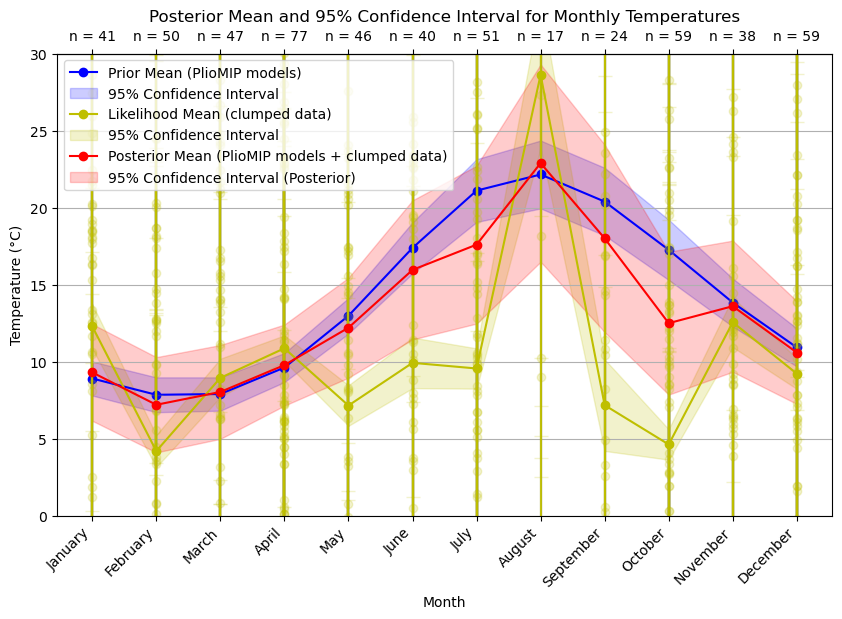

In [41]:
# Plot the updated posterior
std_prior_original = np.sqrt(np.diag(cov_prior_original))
std_post = np.sqrt(np.diag(cov_prior))

# Initiate plot
plt.figure(figsize = (10, 6))
# PRIOR
# Add prior mean
plt.plot(months, mu_prior_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months,
    mu_prior_original - stats.t.ppf(1 - 0.025, n_models) * std_prior_original / np.sqrt(n_models),
    mu_prior_original + stats.t.ppf(1 - 0.025, n_models) * std_prior_original / np.sqrt(n_models), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# LIKELIHOOD
# Add likelihood mean
plt.plot(months, mu_likelihood, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(months,
    mu_likelihood - stats.t.ppf(1 - 0.025, n_update) * std_likelihood / np.sqrt(n_update),
    mu_likelihood + stats.t.ppf(1 - 0.025, n_update) * std_likelihood / np.sqrt(n_update), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(measurement["month_score"], measurement["temp_strict"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["month_score"], measurement["temp_strict"], yerr = measurement["temp_strict_SD"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update])
secax.tick_params(axis = 'x', rotation = 0)
# POSTERIOR
# Add posterior mean
plt.plot(months, mu_prior, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months,
    mu_prior - stats.t.ppf(1 - 0.025, (n_update + n_models)) * std_post,
    mu_prior + stats.t.ppf(1 - 0.025, (n_update + n_models)) * std_post,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)
# Plot layout
plt.xticks(months, month_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Monthly Temperatures')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.ylim(0, 30)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

## Plot seasonal posterior

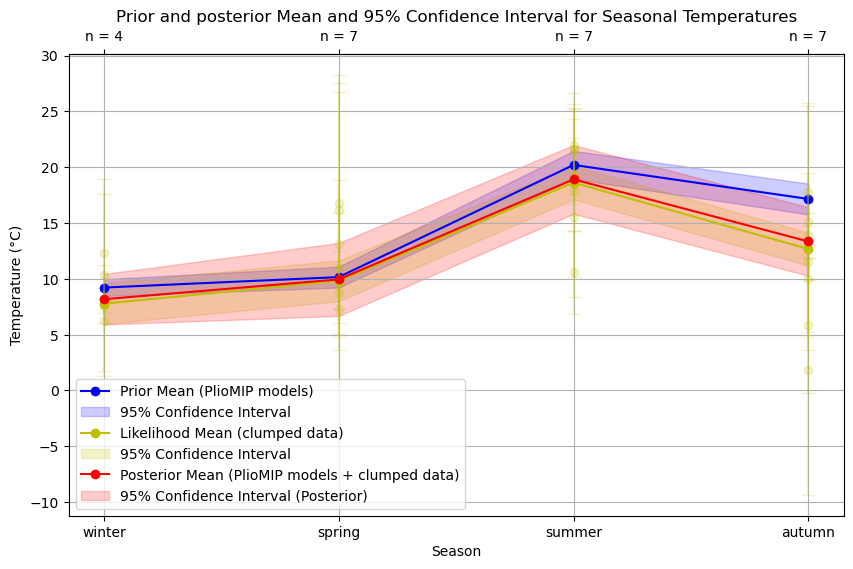

In [43]:
# Plot the updated seasonal posterior
std_post_seasonal = np.sqrt(np.diag(cov_prior_seasonal))
std_prior_seasonal_original = np.sqrt(np.diag(cov_prior_seasonal_original))

# Initiate figure
plt.figure(figsize = (10, 6))
# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_seasonal_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_original / np.sqrt(n_models_seasonal),
    mu_prior_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_original / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonal, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonal - stats.t.ppf(1 - 0.025, n_update_seasonal) * std_likelihood_seasonal / np.sqrt(n_update_seasonal),
    mu_likelihood_seasonal + stats.t.ppf(1 - 0.025, n_update_seasonal) * std_likelihood_seasonal / np.sqrt(n_update_seasonal), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_seasonal_dict: # Loop over measurements
    plt.plot(measurement["season"], measurement["T_mean"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["season"], measurement["T_mean"], yerr = measurement["T_sd"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonal])
secax.tick_params(axis = 'x', rotation = 0)
# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_prior_seasonal, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_seasonal - stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_seasonal,
    mu_prior_seasonal + stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_seasonal,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)
# Plot layout
plt.xticks(seasons_scale, season_names)
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal Temperatures')
plt.xlabel('Season')
plt.ylabel('Temperature (°C)')
# plt.ylim(0, 30)
plt.legend()
plt.grid(True)
plt.show()